Import base fire perimeter map

In [ ]:
## Note: The following packages must be installed:
# pip install geopandas pandas matplotlib requests jupyter ipykernel contextily

import geopandas as gpd

In [ ]:
# initialize the geodataframe, select fire perimeters. For prescribed burns, select "rxburn24_1" instead of "firep24_1"
gdf = gpd.read_file("../data/raw/fire24_1.gdb", layer="firep24_1")
print(gdf.shape) #Geodataframe dimensions
print(gdf.crs) #Coordinate reference system - EPSG 3310 = California Albers projection
print(gdf.columns.tolist())

(22810, 20)
EPSG:3310
['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'IRWINID', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'COMPLEX_NAME', 'COMPLEX_ID', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'FIRE_NUM', 'Shape_Length', 'Shape_Area', 'geometry']


<Axes: >

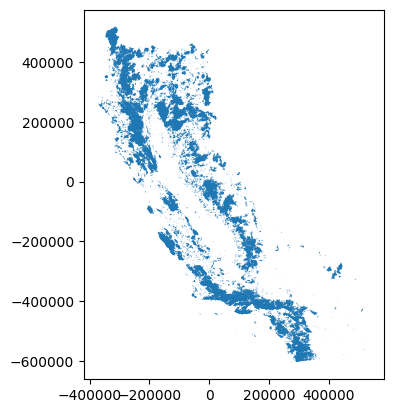

In [9]:
gdf.plot()

Import base map

In [13]:
import contextily as ctx
import matplotlib.pyplot as plt

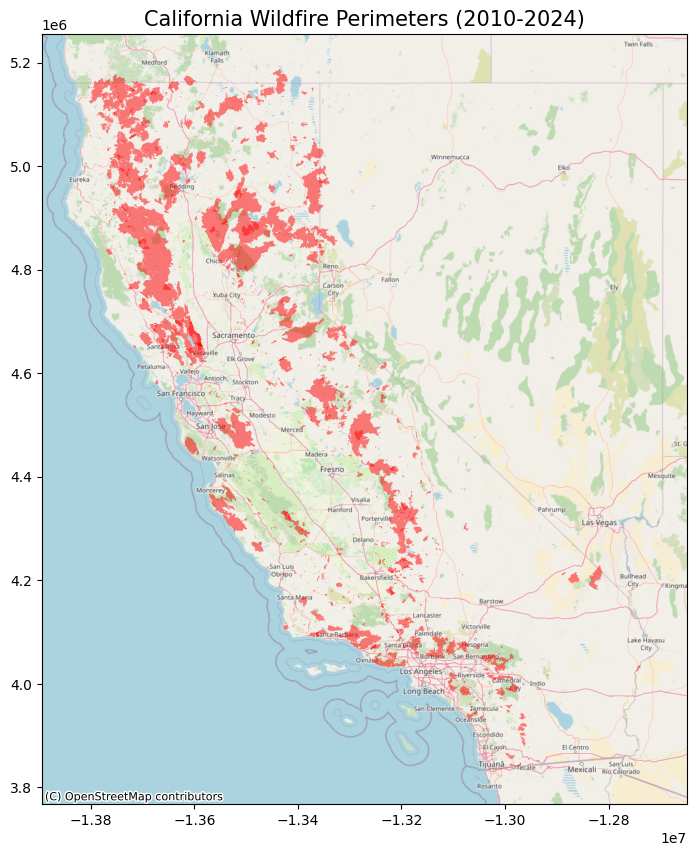

In [30]:
# Filter basemap to 2010 fires and onward
gdf.recent = gdf[gdf['YEAR_'] >= 2010]

# Convert CRS to Web Mercator for contextily basemap
gdf.web = gdf.recent.to_crs(epsg=3857)

# Plot the fire perimeters
fig, ax= plt.subplots(figsize=(10,10))
gdf.web.plot(ax=ax, alpha=0.5, color="red")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("California Wildfire Perimeters (2010-2024)", fontsize=15)
plt.show()

Add interactivity via ipywidgets for quick analyses

In [32]:
# Enter the following into Bash terminal:
# pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

In [33]:
def plot_year(year):
    gdf_year = gdf[gdf['YEAR_'] == year].to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10,10)) #Initialize new dataset to matching years only, then create new canvas for each year
    gdf_year.plot(ax=ax, alpha=0.5, color="red")
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title(f"California Wildfire Perimeters - {year}", )
    plt.show()

widgets.interact(plot_year, year=widgets.IntSlider(
    min=2010, max=2024, step=1, value=2010))



interactive(children=(IntSlider(value=2010, description='year', max=2024, min=2010), Output()), _dom_classes=(…

<function __main__.plot_year(year)>